In [1]:
import networkx as nx
import os
import itertools
import pickle
import matplotlib.pyplot as plt
import graphlab
from graphlab import aggregate as agg
import numpy as np
from datetime import datetime
import community
from collections import OrderedDict
%matplotlib inline

## A. The collaboration network

A natural way to represent this data is as a collaboration network between authors. Each node in the network is an author, and they are connected by a link if they have co-authored a paper. Link weights given by the number of papers co-authored by that pair of authors. 

To construct this network, we begin by loading the authors table and produce a new table that lists all the authors of each paper. The head of this table looks like this:

In [26]:
authors = graphlab.SFrame.read_csv('170331_PURE_Data_Challenge/PURE Data Challenge/authors.csv', delimiter=',', skiprows=0, na_values=['NA','NULL'], verbose=False)
pub_authors = authors.groupby(key_columns='PUBLICATION_ID', operations={'authors':agg.CONCAT('PERSON_ID')})
pub_authors.print_rows(num_rows=5)

+----------------+-----------------------+
| PUBLICATION_ID |        authors        |
+----------------+-----------------------+
|    35729578    |        [57489]        |
|    47837678    |        [60777]        |
|    2405192     |        [20049]        |
|    2381438     | [19903, 15595, 22998] |
|    8932663     |        [46554]        |
+----------------+-----------------------+
[29664 rows x 2 columns]



In [16]:
f=open('./publication_net_links_dict.pkl', 'rb')
_pub_links = pickle.load(f)
f.close()

In [35]:
weights = [len([author for author in pub_authors.filter_by(column_name='PUBLICATION_ID',values=link)['authors'][0] if author in pub_authors.filter_by(column_name='PUBLICATION_ID',values=link)['authors'][1]]) for link in _pub_links]

KeyboardInterrupt: 

In [ ]:
publication_net_links = dict(zip(_pub_links, weights))

#### We then construct a dictionary representation of the link weights between pairs of authors, and create a *networkx* instance:

In [7]:
def create_collab_net(links):
    '''Take dictionary of links and produce networkx graph.'''
    
    nodes = []
    for l in links.keys():
        if l[0] not in nodes:
            nodes.append(l[0])
        if l[1] not in nodes:
            nodes.append(l[1])
            
    G = nx.Graph()
    G.add_nodes_from(nodes)
    for l in links.keys():
        G.add_edge(*l, weight=links[l])
        
    return G

In [9]:
solo_count = 0
links = dict()
for pub in pub_authors:
    
    if len(pub['authors'])==1:
        solo_count += 1
    else:
        _links = itertools.combinations(pub['authors'],2)
        for l in _links:
            if l not in links.keys():
                links[l] = 1
            else:
                links[l] +=1
                
G = create_collab_net(links)

print "Network created:"
print "There are %d nodes in this network," %len(G.nodes())
print "And %d edges." %len(G.edges())

Network created:
There are 2561 nodes in this network,
And 9268 edges.


#### With each auhtor plotted on the edge of a cirlce, the whole collaboration network looks like this:

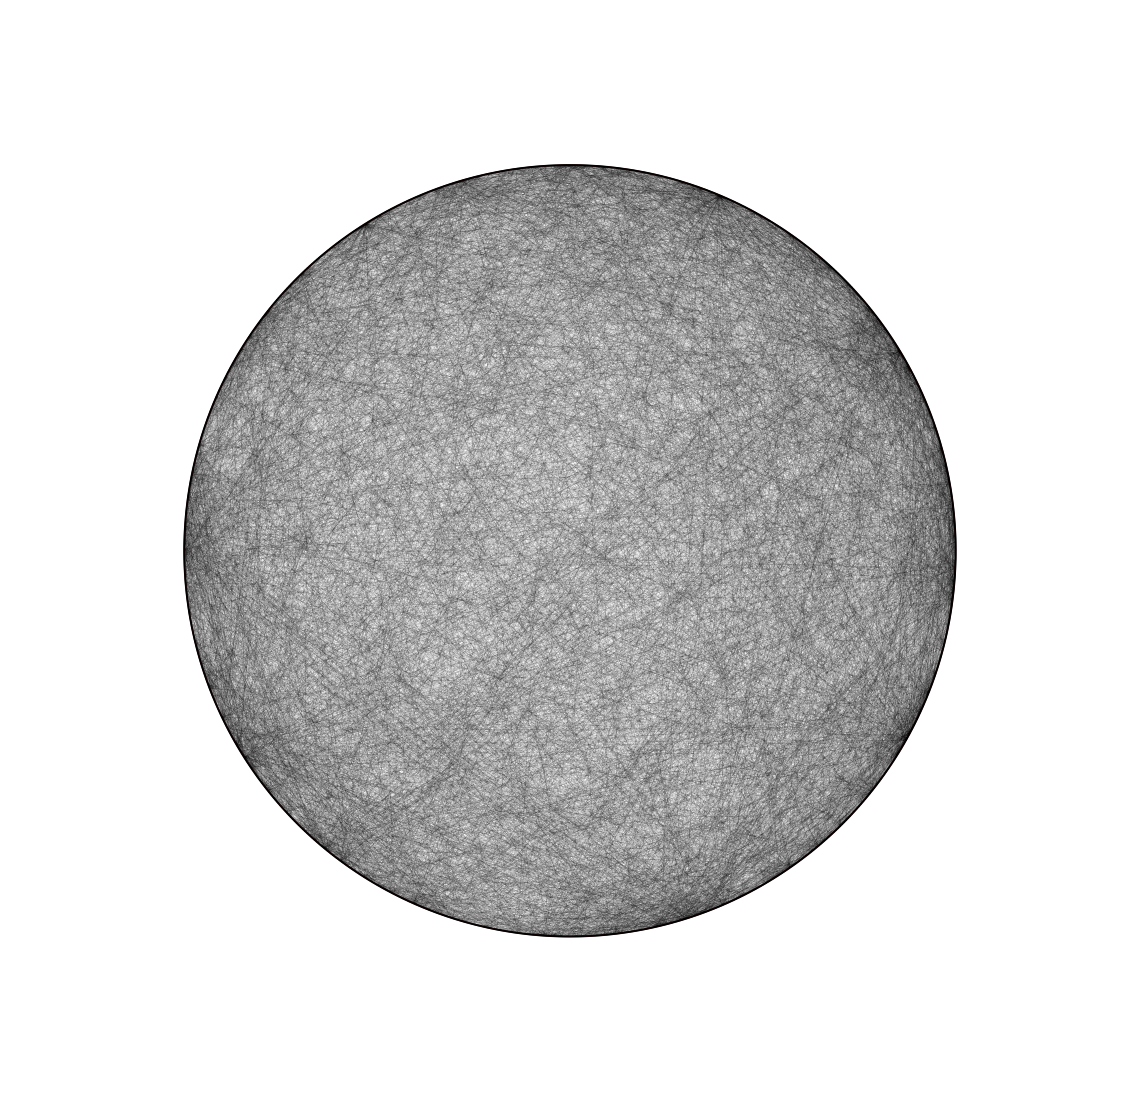

In [13]:
plt.figure(figsize=(15,15))
nx.draw_circular(G, node_size=1, width=0.05)

#### Beyond an appreciation of the complexity of the collaborations ongoing at the University, there is not much to be learned from the previous network image. But we can simplify the representation by aggregating authors into groups. A natural node grouping, or *partition* of the network, is given by the *organisation* to which each author belongs. 

Using the package *community* we can plot the induced graph that is given when we aggregate authors into organisations:

In [ ]:
## We load the staff data, and assign an integer id (orgid) to each ORGANISATION_CODE that is in use.
## There is some duplication in the staff table, so we filter duplicate entries.
staff = graphlab.SFrame.read_csv('170331_PURE_Data_Challenge/PURE Data Challenge/staff.csv', delimiter=',', skiprows=0, na_values=['NA','NULL'])
orgs = staff['ORGANISATION_CODE'].unique()
orgdict = dict()
for ii,org in enumerate(orgs):
    orgdict[org] = ii
    
staff['orgid'] = staff['ORGANISATION_CODE'].apply(lambda org: orgdict[org])
staff = staff.groupby(key_columns='PERSON_ID', operations={
                                            'ORGANISATION_CODE':agg.SELECT_ONE('ORGANISATION_CODE'),
                                            'TYPE':agg.SELECT_ONE('TYPE'),
                                            'orgid':agg.SELECT_ONE('orgid'),
                                        })

In [22]:
def _calc_group_sizes(part):
    '''Calculates groups sizes for a given partition (dict)'''
    community_sizes = OrderedDict.fromkeys(np.unique(part.values()),0)
    for node in part.keys():
        community_sizes[part[node]] += 1
        
    return community_sizes

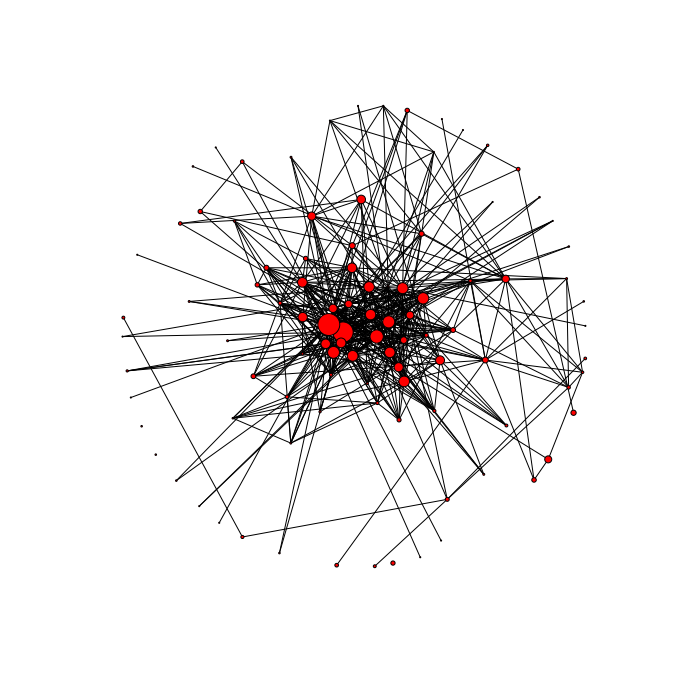

In [38]:
node_scaling = 1.2
partition_pure = dict(zip(staff['PERSON_ID'], staff['orgid']))
IG = community.induced_graph(graph=G, partition=partition_pure)
organisation_sizes = _calc_group_sizes(partition_pure)

plt.figure(figsize=(9,9))
pos = nx.spring_layout(IG,k=0.2)
nx.draw(IG, pos=pos, nodelist=[node for node in IG.nodes()], node_size=[node_scaling * organisation_sizes[node] for node in IG.nodes()])

The above plot uses a spring layout - we notice a core of larger organisations that collaborate strongly with others, surrounded by a periphery of smaller and more insular (specialised) organisations. Three small organisations have only internal collaborations.

#### It is clear that there is a significant amount of research that crosses organisational boundaries - is this interdisciplinary research?

#### In fact the organisational strucutre of the university is a hierarchical tree that looks like this:

In [ ]:
hierarchy = graphlab.SFrame.read_csv('170331_PURE_Data_Challenge/PURE Data Challenge/org_hierarchy.csv', delimiter=',', skiprows=0, na_values=['NA','NULL'])
orgkey = graphlab.SFrame.read_csv('170331_PURE_Data_Challenge/PURE Data Challenge/org_key.csv', delimiter=',', skiprows=0, na_values=['NA','NULL'])

In [42]:
H = nx.DiGraph()

added =[]
for row in hierarchy:
    n1 = row['PARENT_ORG_CODE']
    n2 = row['CHILD_ORG_CODE']
    
    if n1 not in added:
        H.add_node(n1)
        added.append(n1)
    if n2 not in added:
        H.add_node(n2)
        added.append(n2)
        
for row in hierarchy:
    n1 = row['PARENT_ORG_CODE']
    n2 = row['CHILD_ORG_CODE']
    H.add_edge(n1,n2)

In [40]:
## Credit to: stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3
def hierarchy_pos(G, root, width=5., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = G.neighbors(root)
    if parent != None and parent in neighbors:
        #print parent
        #print neighbors
        neighbors.remove(parent)
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos

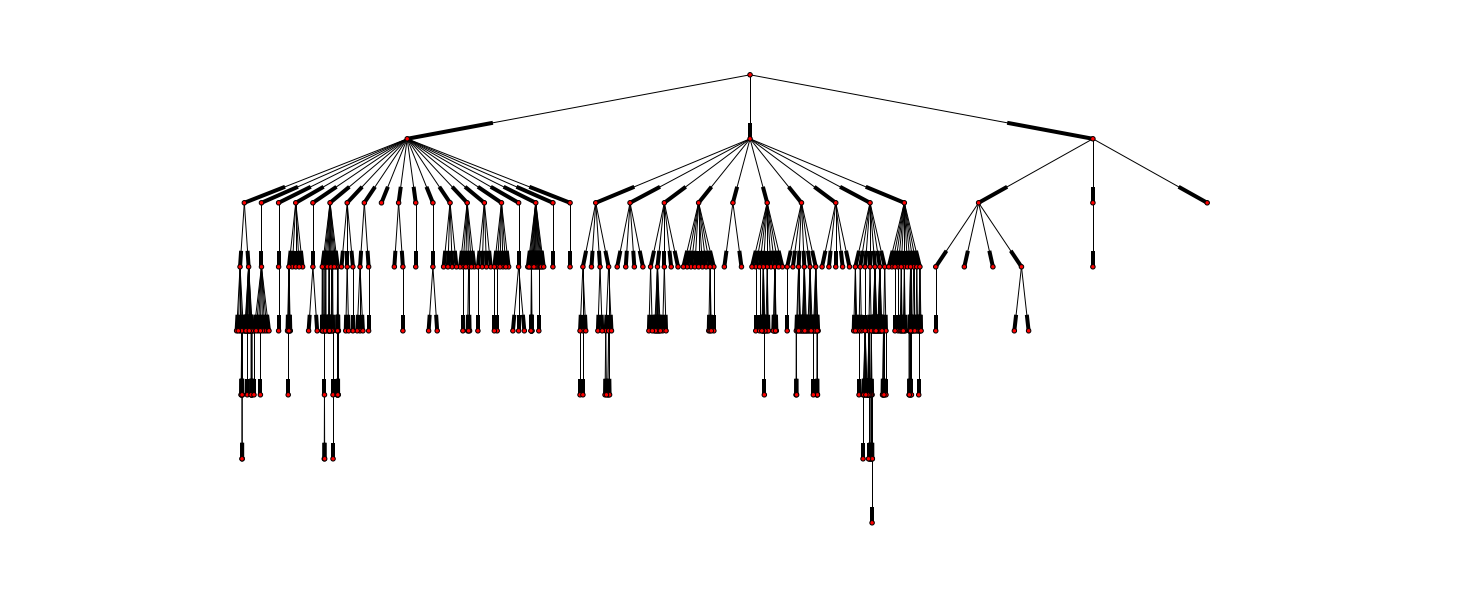

In [43]:
pos = hierarchy_pos(H,'UNIV')    
plt.figure(figsize=(20,8))
nx.draw(H, pos=pos, with_labels=False, node_size=20)

With the whole University as the root of the tree, and child organisations below. If we were to aggregate our collaboration network at some higher level of the tree, we would lose some of the smaller nodes and, perhaps, some of the apparent interdisciplinarity.

#### But who is to say the standard organisational structure is that which best encodes the research?

#### We can use *community detection* to identify groups of authors that collaborate more within the group than without. This is done by optimising the *modularity* given by a community structure.

We use the Louvain algorithm **[REF]** which gives sequential levels of community structure - with fewer communities of increasing size at each level. The final level is the *best* community structure achieved by the algorithm.

#### For our collaboration network the algorithm produces three level of community structure.

The first level contains 407 communities, and the induced graph looks like this:

(When communities are plotted on concentric circles, with isolates in the outer ring.)

In [45]:
den = community.generate_dendrogram(G)
part0 = den[0]

part1=dict()
for key in part0.keys():
    part1[key] = den[1][part0[key]]

part2=dict()
for key in part0.keys():
    part2[key] = den[2][part1[key]]

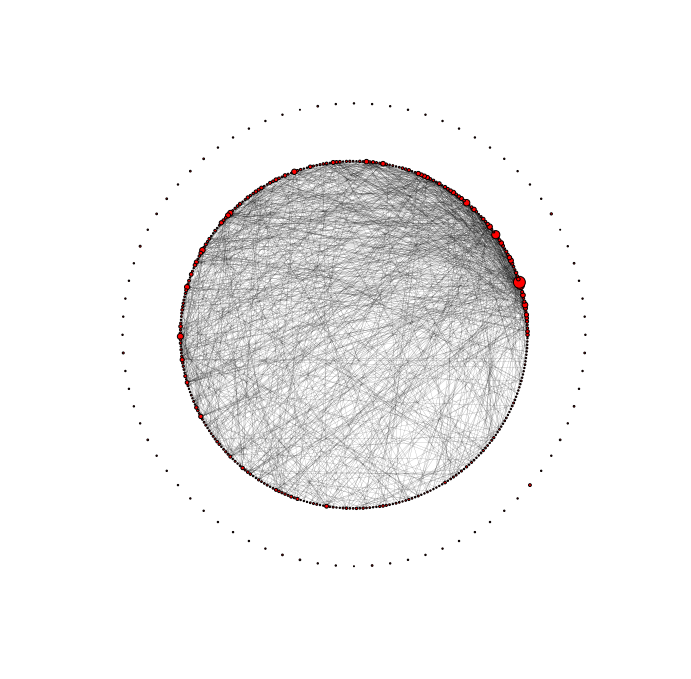

In [51]:
IG = community.induced_graph(graph=G, partition=part0)
community_sizes = _calc_group_sizes(part0)

plt.figure(figsize=(9,9))
test_nodes = IG.nodes()
isolates  = []
for node in test_nodes:
    node_in_edges = False
    for ed in IG.edges():
        if node in ed and ed[0]!=ed[1]:
            node_in_edges = True
            break
    
    if not node_in_edges:
        isolates.append(node)

connected = [node for node in IG.nodes() if node not in isolates]        
_sub0 = IG.subgraph(nbunch=isolates)
_sub1 = IG.subgraph(nbunch=connected)

nx.draw_circular(_sub0, nodelist=_sub0.nodes(), node_size=[community_sizes[n] for n in _sub0.nodes()])
pos = nx.circular_layout(_sub1)
for p in pos.keys():
    pos[p][0] = pos[p][0]*0.75 + 0.125
    pos[p][1] = pos[p][1]*0.75 + 0.125
    
nx.draw(_sub1, pos=pos, nodelist=_sub1.nodes(), node_size=[community_sizes[n] for n in _sub1.nodes()], width=0.1)

The second level contains 129 communities and looks like this:

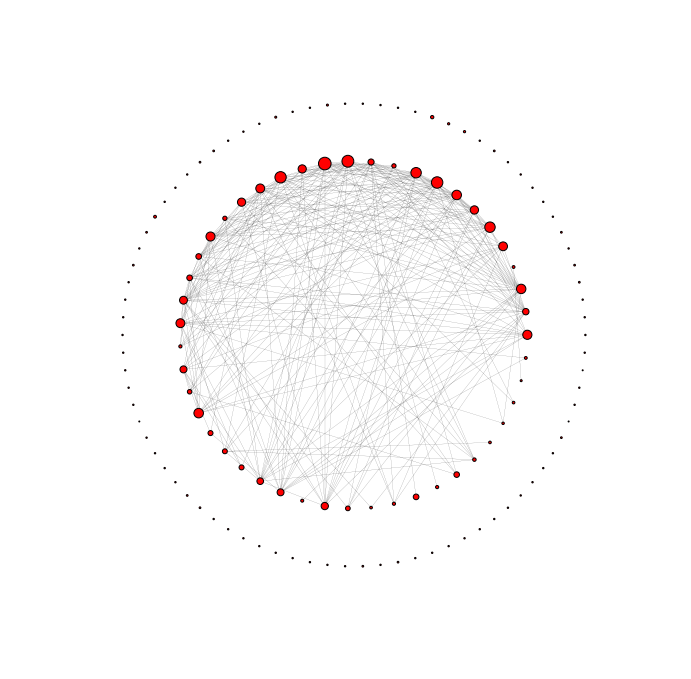

In [56]:
IG = community.induced_graph(graph=G, partition=part1)
community_sizes = _calc_group_sizes(part1)

plt.figure(figsize=(9,9))
test_nodes = IG.nodes()
isolates  = []
for node in test_nodes:
    node_in_edges = False
    for ed in IG.edges():
        if node in ed and ed[0]!=ed[1]:
            node_in_edges = True
            break
    
    if not node_in_edges:
        isolates.append(node)

connected = [node for node in IG.nodes() if node not in isolates]        
_sub0 = IG.subgraph(nbunch=isolates)
_sub1 = IG.subgraph(nbunch=connected)

nx.draw_circular(_sub0, nodelist=_sub0.nodes(), node_size=[community_sizes[n] for n in _sub0.nodes()])
pos = nx.circular_layout(_sub1)
for p in pos.keys():
    pos[p][0] = pos[p][0]*0.75 + 0.125
    pos[p][1] = pos[p][1]*0.75 + 0.125
    
nx.draw(_sub1, pos=pos, nodelist=_sub1.nodes(), node_size=[community_sizes[n] for n in _sub1.nodes()], width=0.1)

In [58]:
len(np.unique(part2.values()))

110

And the best partition, given by the third level contains 110 communities and looks like this:

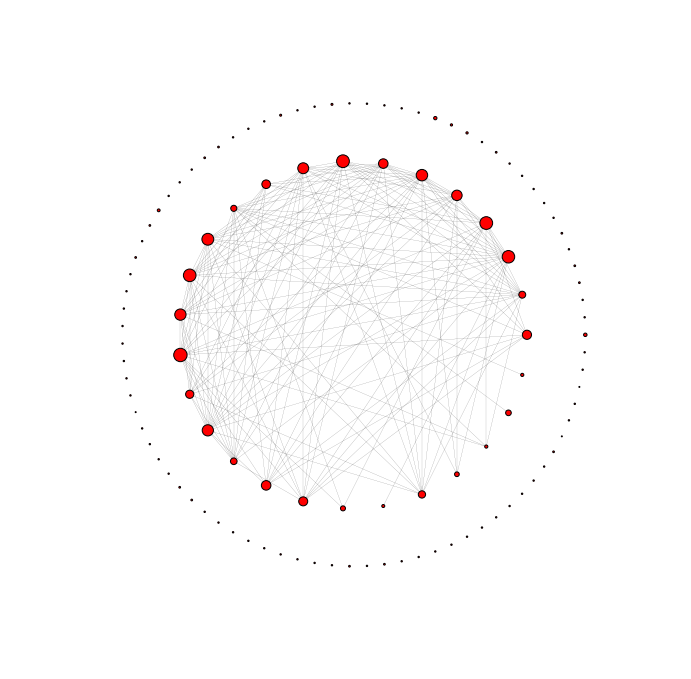

In [60]:
IG = community.induced_graph(graph=G, partition=part2)
community_sizes = _calc_group_sizes(part2)

plt.figure(figsize=(9,9))
test_nodes = IG.nodes()
isolates  = []
for node in test_nodes:
    node_in_edges = False
    for ed in IG.edges():
        if node in ed and ed[0]!=ed[1]:
            node_in_edges = True
            break
    
    if not node_in_edges:
        isolates.append(node)

connected = [node for node in IG.nodes() if node not in isolates]        
_sub0 = IG.subgraph(nbunch=isolates)
_sub1 = IG.subgraph(nbunch=connected)

nx.draw_circular(_sub0, nodelist=_sub0.nodes(), node_size=[community_sizes[n] for n in _sub0.nodes()])
pos = nx.circular_layout(_sub1)
for p in pos.keys():
    pos[p][0] = pos[p][0]*0.75 + 0.125
    pos[p][1] = pos[p][1]*0.75 + 0.125
    
nx.draw(_sub1, pos=pos, nodelist=_sub1.nodes(), node_size=[community_sizes[n] for n in _sub1.nodes()], width=0.1)

To compare this to the partition givne by the organisations:
* More isolates - coherent fields of study?
* Lower connectivity in the connected component **VAL**

#### So the community detection prodcues a new grouping, based of closeness of collaborations, that does not honour the organisational strucutre of the university. Perhaps these grouping represent new fields of knowledge?

In Ecology the *Shanon entropy* **[REF]** is often used to calculate the diversity of an ecosystem. Here we use this metric to determine the organisational diversity of each community.  

In [68]:
def _shanon(community, staff):
    '''Calculates the Shanon (organisational) diversity of a given community.'''
    
    _community_staff = staff.filter_by(column_name='PERSON_ID', values=community)
    organisational_partition = dict(zip(_community_staff['PERSON_ID'], _community_staff['orgid']))
    org_sizes = _calc_group_sizes(organisational_partition)
    
    
    total = sum(org_sizes.values())
    diversity = [(size/float(total))*np.log(size/float(total)) for size in org_sizes.values()]
    
    return - sum(diversity)

In [86]:
community_diversity_best_partition = graphlab.SFrame()
community_diversity_best_partition['comid'] = np.unique(part2.values())
div_col = []
for com in community_diversity_best_partition['comid']:
    com = [key for key in part2 if part2[key]==com]
    div_col.append(_shanon(com, staff))
    
community_diversity_best_partition['diversity'] = div_col

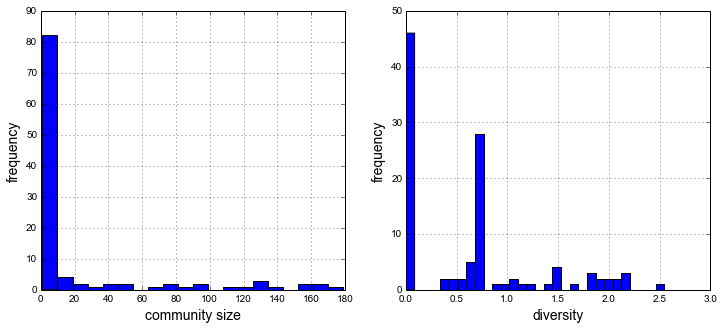

In [87]:
fsa =14
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(_calc_group_sizes(part).values(), bins=20)
plt.xlabel('community size', fontsize=fsa)
plt.ylabel('frequency', fontsize=fsa)
plt.grid()

plt.subplot(1,2,2)
plt.hist(community_diversity_best_partition['diversity'], bins=30)
plt.xlabel('diversity', fontsize=fsa)
plt.ylabel('frequency', fontsize=fsa)
plt.grid()

We see that the distribution of diversities is bi-modal. It has a peak at zero, corresponding to communities that contain authors from a single organisation. It has a second peak in diversity close to 0.7. We now inspect communites close to this peak and above.. 

#### The most diverse commnuity looks like this:

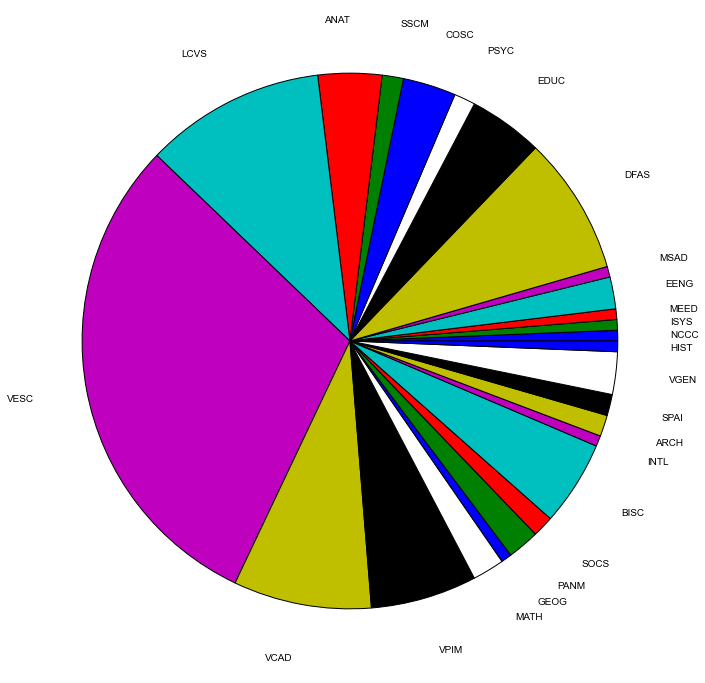

In [89]:
ordered = community_diversity_best_partition.sort('diversity', ascending=False)
top_com = ordered[0]['comid']

ids_in_com = [node for node in part2.keys() if part2[node]==top_com]
com = staff.filter_by(column_name='PERSON_ID', values=ids_in_com).groupby('orgid', operations={'count':agg.COUNT('PERSON_ID'), 'code':agg.SELECT_ONE('ORGANISATION_CODE')})
plt.figure(figsize=(12,12))
t=plt.pie(com['count'], labels=com['code'], labeldistance=1.2, )

#### And one community close to the second peak looks like this:

Lots of comms with this same div... 50:50?

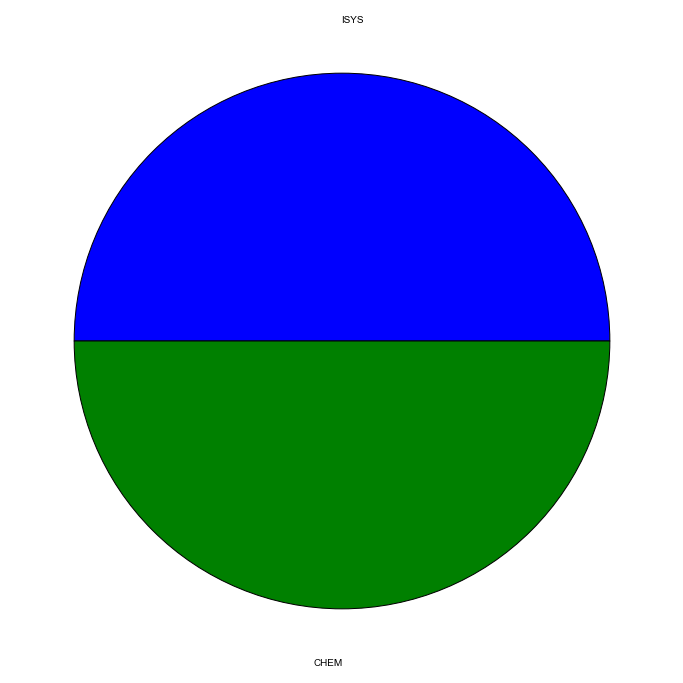

In [90]:
ordered = community_diversity_best_partition.sort('diversity', ascending=False)
ordered = ordered[ordered['diversity']<0.7]
top_com = ordered[0]['comid']

ids_in_com = [node for node in part2.keys() if part2[node]==top_com]
com = staff.filter_by(column_name='PERSON_ID', values=ids_in_com).groupby('orgid', operations={'count':agg.COUNT('PERSON_ID'), 'code':agg.SELECT_ONE('ORGANISATION_CODE')})
plt.figure(figsize=(12,12))
t=plt.pie(com['count'], labels=com['code'], labeldistance=1.2, )

#### As a network the most diverse community looks like:

What is its connectivity compared to the others (distribution), and compared to the overall network..

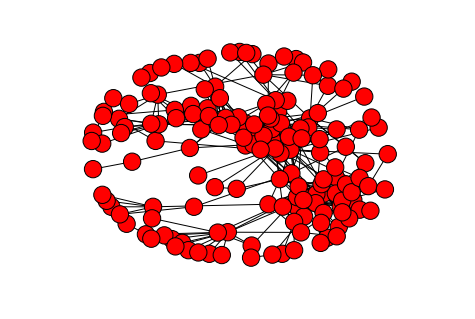

In [98]:
ordered = community_diversity_best_partition.sort('diversity', ascending=False)
top_com = ordered[0]['comid']

ids_in_com = [node for node in part2.keys() if part2[node]==top_com]
_sub = G.subgraph(nbunch=ids_in_com)
nx.draw_spring(_sub)

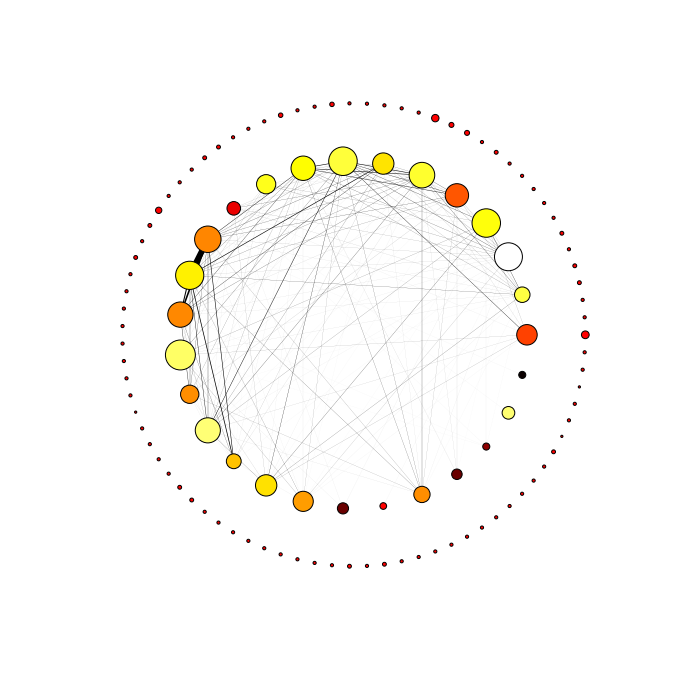

In [121]:
node_scaling = 5
edge_scaling = 0.01
IG = community.induced_graph(graph=G, partition=part2)

plt.figure(figsize=(9,9))
test_nodes = IG.nodes()
isolates  = []
for node in test_nodes:
    node_in_edges = False
    for ed in IG.edges():
        if node in ed and ed[0]!=ed[1]:
            node_in_edges = True
            break
    
    if not node_in_edges:
        isolates.append(node)

connected = [node for node in IG.nodes() if node not in isolates]        
_sub0 = IG.subgraph(nbunch=isolates)
_sub1 = IG.subgraph(nbunch=connected)

nx.draw_circular(_sub0, nodelist=_sub0.nodes(), node_size=[node_scaling * community_sizes[n] for n in _sub0.nodes()])
#pos = nx.spring_layout(_sub1)
pos = nx.circular_layout(_sub1)
for p in pos.keys():
    pos[p][0] = pos[p][0]*0.75 + 0.125
    pos[p][1] = pos[p][1]*0.75 + 0.125

#print plt.colormaps()

diversity_dict = dict(zip(community_diversity_best_partition['comid'], community_diversity_best_partition['diversity']))
_temp = nx.draw_networkx_nodes(_sub1, pos=pos, nodelist=_sub1.nodes(), node_size=[node_scaling * community_sizes[n] for n in _sub1.nodes()], node_color=[diversity_dict[n] for n in _sub1.nodes()], cmap='hot', width=0.5)
_temp = nx.draw_networkx_edges(_sub1, pos=pos, edgelist=[edge for edge in _sub1.edges()], width=[edge_scaling * _sub1.get_edge_data(edge[0], edge[1])['weight'] for edge in _sub1.edges()])

In [118]:
print IG.get_edge_data(u=2,v=5)

{'weight': 7}


### We now want to:

* get further partitions (different granularity, unweigthed, different algorithm, randomly assigned)
* compare: 1) modularity, and 2) mutual information between these different parititions. 

In [85]:
partition_frame = graphlab.SFrame()
partition_frame['PERSON_ID'] = part.keys()
partition_frame['com_id'] = part.values()

In [83]:
test = partition_frame.join(staff, on='PERSON_ID', how='inner')

# Need MI from scipy

In [29]:
ncoms = len(np.unique(part0.values()))
part0_rand = dict(zip(part0.keys(), np.random.randint(0, size=len(part0), high=ncoms) )) 

ncoms = len(np.unique(part1.values()))
part1_rand = dict(zip(part1.keys(), np.random.randint(0, size=len(part1), high=ncoms) )) 

ncoms = len(np.unique(part.values()))
part_rand = dict(zip(part.keys(), np.random.randint(0, size=len(part), high=ncoms) )) 

In [30]:
print community.modularity(graph=G, partition=part0)
print community.modularity(graph=G, partition=part1)
print community.modularity(graph=G, partition=part)
print '\n'
print community.modularity(graph=G, partition=part0_rand)
print community.modularity(graph=G, partition=part1_rand)
print community.modularity(graph=G, partition=part_rand)

0.679604668696
0.786570545604
0.79354695468


-0.000304723849695
0.00234606662185
-3.08695179694e-05


In [99]:
import sklearn.metrics as sklm

In [107]:
node_order = part.keys()
print sklm.mutual_info_score([part0[node] for node in node_order], [partition_pure[node] for node in node_order])
print sklm.mutual_info_score([part1[node] for node in node_order], [partition_pure[node] for node in node_order])
print sklm.mutual_info_score([part[node] for node in node_order], [partition_pure[node] for node in node_order])
print 'random assignment:'
print sklm.mutual_info_score([part_rand[node] for node in node_order], [partition_pure[node] for node in node_order])

print '\n'
node_order = part.keys()
print sklm.adjusted_mutual_info_score([part0[node] for node in node_order], [partition_pure[node] for node in node_order])
print sklm.adjusted_mutual_info_score([part1[node] for node in node_order], [partition_pure[node] for node in node_order])
print sklm.adjusted_mutual_info_score([part[node] for node in node_order], [partition_pure[node] for node in node_order])
print sklm.adjusted_mutual_info_score([partition_pure[node] for node in node_order], [partition_pure[node] for node in node_order])
print 'random assignment:'
print sklm.adjusted_mutual_info_score([part_rand[node] for node in node_order], [partition_pure[node] for node in node_order])

2.69998006515
2.10463608993
1.84996205811
random assignment:
0.893883193329


0.29062577811
0.422779700114
0.446687676349
1.0
random assignment:
-0.00202101866978


### We now want to look at community diversity:

* Based on ecology calucalte Shannon diversity for each com
* Plot diversity distirbution
* Study (pie) most and least diverse communities
* Colour collaboration network plot according to diversity

## Try out the jacard score! 
## find implementation of Shanon bio-diversity